In [1]:
import numpy as np; import pylab as pl; import os, time, pickle; import matplotlib.pyplot as plt
ITD_limit = 160
stim_no = 33
stim_range = np.arange(-ITD_limit, ITD_limit, 2*ITD_limit/stim_no)
N = 12500
simtime = 1*1000.
t_trans = 150.
f = open('po_init', 'rb'); pitds = pickle.load(f); f.close()
po_init=pitds

n_cores = 4
trial_no = 20
tr=0

In [2]:
import neo
import elephant.statistics as stats
import quantities as pq

In [3]:
raiz = 'Results/N12500g8_Jrec=0.01/spikes-all-st{stim}-tr{tr}-12501-{core}.dat'

In [4]:
def pega_resultados(raiz, tr=0, stim=0):
    spkt = []
    for core in range(n_cores):
        spkt.append(np.loadtxt(raiz.format(core=core, tr=tr, stim=stim), skiprows=3))
    return np.concatenate(spkt)
    
def generate_spktm(file):
    spike_trains = [file[:,1][np.where(file[:,0]==n)[0]] for n in range(1,N+1)]

    return spike_trains

def plot_raster(spike_time_matrix, fig_size=(20,10), colors = ["r", "b"]):
    plt.figure(figsize=fig_size)
    for i in range(int(N*0.8)):
        if len(spike_time_matrix[i]) != 0:
            plt.plot(spike_time_matrix[i], i*np.ones(len(spike_time_matrix[i])),"o", c=colors[0], markersize=1)
    for i in range(int(N*0.8),N):
        if len(spike_time_matrix[i]) != 0:
            plt.plot(spike_time_matrix[i], i*np.ones(len(spike_time_matrix[i])),"o", c=colors[1], markersize=1)

def calculate_fr(file):
    senders = file[:,0]
    fr = np.array([len(np.where(senders == n)[0]) / ((simtime-t_trans)/1000) for n in range(1,N+1)])
    return fr

def compute_inst_fr(spike_time_matrix):
    neo_spktm = [neo.SpikeTrain(spike_time_matrix[n], t_stop=1000*pq.ms, units="ms") for n in range(N)]

    # Compute and plot the PSTH
    bin_size = 10 * pq.ms

    psth_exc = stats.time_histogram(neo_spktm[:int(N*0.8)], bin_size, output='rate')
    psth_inh = stats.time_histogram(neo_spktm[int(N*0.8):], bin_size, output='rate')
    fig, ax = plt.subplots(1, 1, figsize=(20,2))
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Firing rate (Hz)")
    plt.plot(psth_exc.times.rescale('s'), psth_exc.rescale('Hz'),'r')
    plt.plot(psth_inh.times.rescale('s'), psth_inh.rescale('Hz'),'b')
    plt.show()

In [5]:
file = pega_resultados(raiz)

In [6]:
spktm = generate_spktm(file)

Text(0, 0.5, '#Neuron')

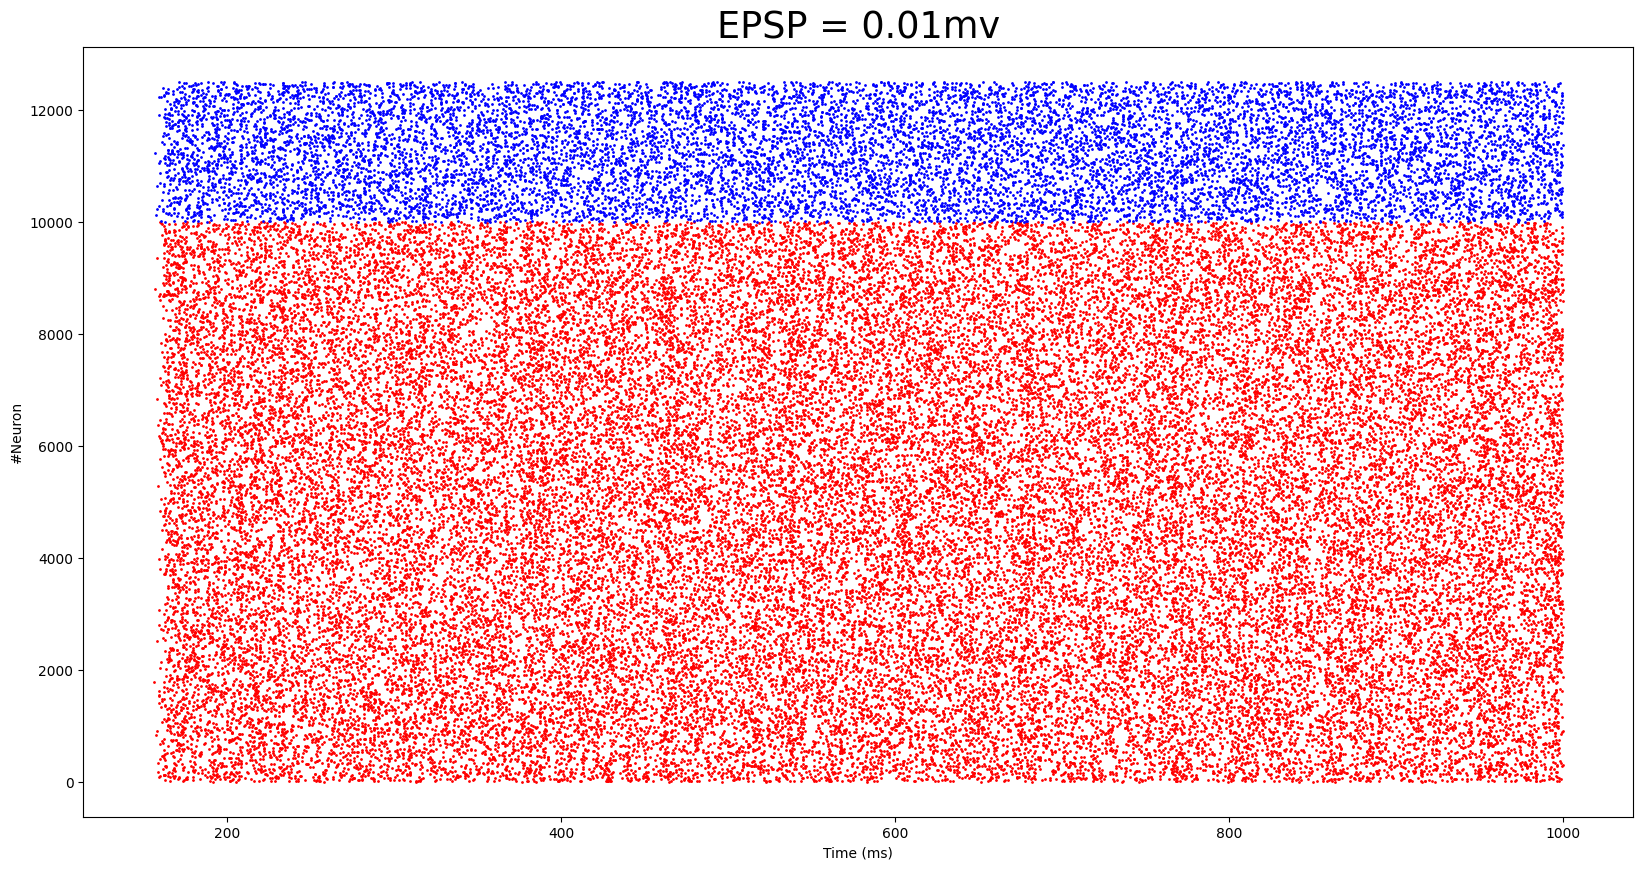

In [7]:
plot_raster(spktm)
plt.rcParams.update({'font.size': 22})
plt.title(f"EPSP = {0.01}mv")
plt.rcParams.update({'font.size': 22})
plt.xlabel("Time (ms)")
plt.ylabel("#Neuron")


In [8]:
frs = calculate_fr(file)

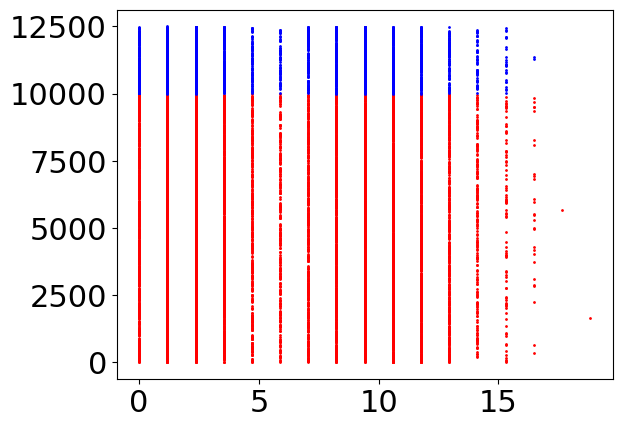

In [9]:
for i in range(int(N*0.8)):
    plt.plot(frs[i], i,"o", c="r", markersize=1)
for i in range(int(N*0.8),N):
    plt.plot(frs[i], i,"o", c="b", markersize=1)

/home/lavinia-lascon/anaconda3/envs/lascon/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


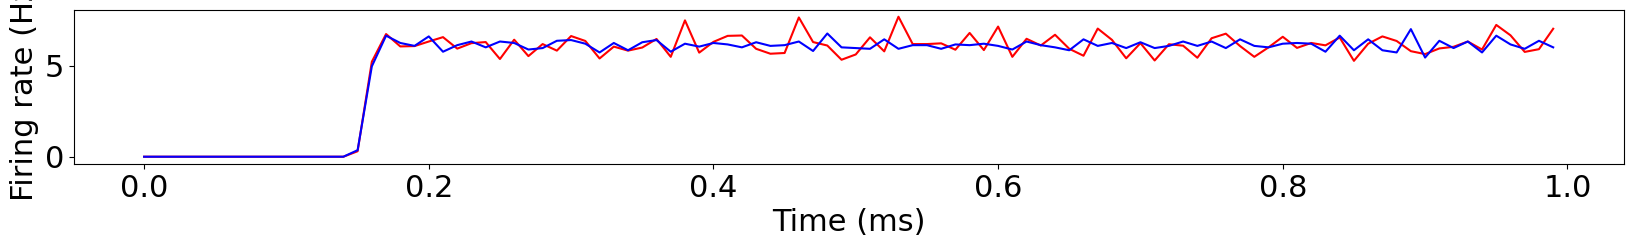

In [10]:
compute_inst_fr(spktm)

## Getting data from the full experiment

In [11]:
files = []

for tr in range(trial_no):
    file = []
    for stim in range(stim_no):
        file.append(pega_resultados(raiz, tr, stim))
    files.append(file)
    

In [12]:
def generate_TC(file):
    tc = []
    for st in range(len(stim_range)):
        fr = calculate_fr(file[st])
        tc.append(fr)
    return tc

def gen_all_TC(files):
    tcs = []
    for tr in range(trial_no):
        tc = generate_TC(files[tr])
        print(tr)
        tcs.append(tc)
    return tcs

In [13]:
def plot_TC(tc, neurons, label=po_init):
    for neuron in neurons:
        plt.plot(stim_range[:], tc[:,neuron], 'o-', label=round(label[neuron],1))
        plt.xlabel("ITD Estimulo ($\mu$s)")
        plt.ylabel("Firing rate (spike/s)")
    plt.legend(bbox_to_anchor=(1.25,1))

In [14]:
#tcs = gen_all_TC(files)
#file = open('tcs_Jrec=0.01', 'wb'); pickle.dump(tcs, file); file.close()

In [15]:
f = open('tcs_Jrec=0.01', 'rb'); tcs = pickle.load(f); f.close()

In [16]:
np.shape(np.array(tcs)[0,:,0])

(33,)

In [17]:
np.shape(tcs)

(20, 33, 12500)

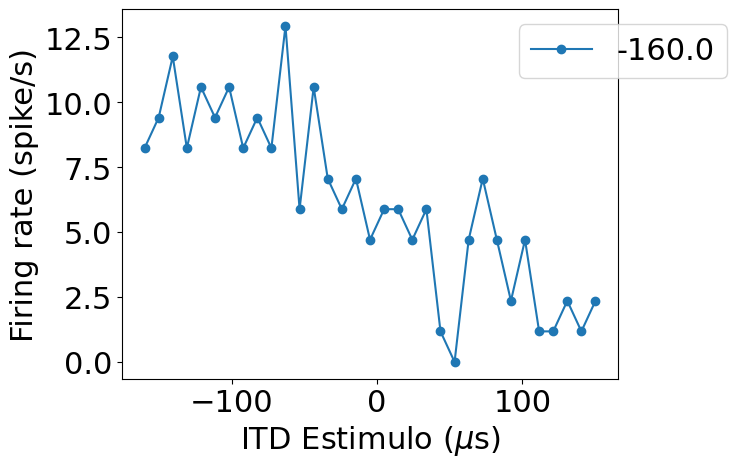

In [18]:
plot_TC(np.array(tcs)[0],range(1,2))

In [19]:
tc_mean = np.mean(tcs, axis=0)

Text(0.5, 1.0, 'EPSP=0.01mV')

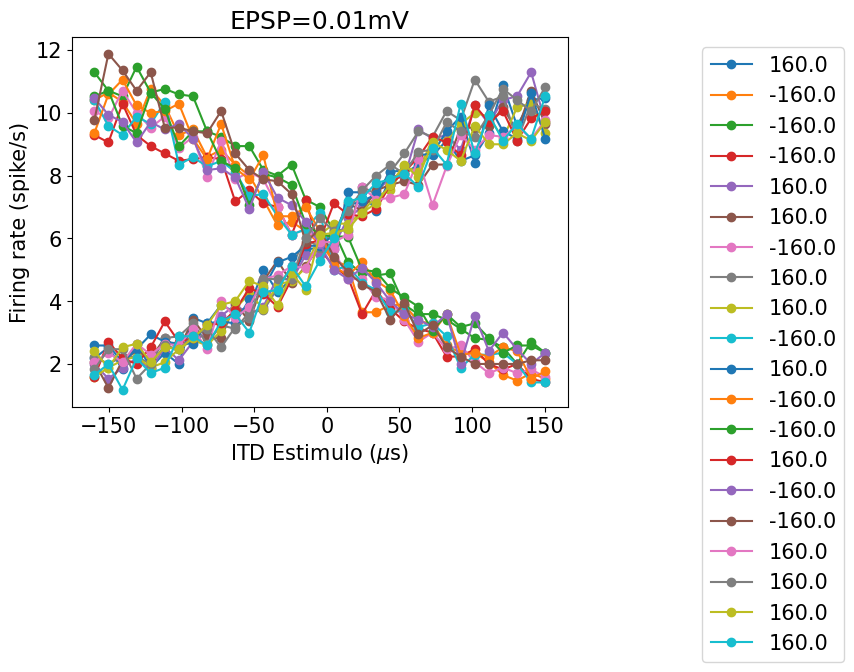

In [20]:
plt.rcParams.update({'font.size': 15})
plot_TC(tc_mean, range(800,820))
plt.title("EPSP=0.01mV")

In [21]:
po_output = []
for n in range(N):
    poo = list(tc_mean[:,n]).index(max(tc_mean[:,n]))
    po_output.append(np.mean(stim_range[poo]))

Text(0.5, 0, 'Output pITD')

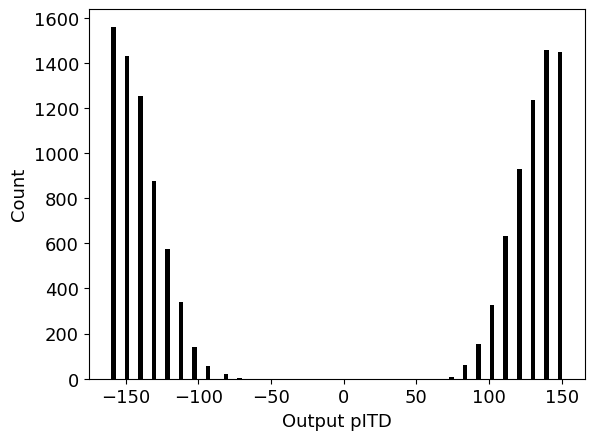

In [22]:
plt.rcParams.update({'font.size': 13})
plt.hist(np.array(po_output), bins = 100, color="k");
#plt.title(f"EPSP:{0.2}mV")
plt.ylabel("Count")
plt.xlabel("Output pITD")

In [23]:
def gen_kde(xs, sigma):
    def gauss(x, mu, sigma):
        return np.exp(-((x - mu) / sigma) ** 2 / 2) / (sigma * np.sqrt(2 * np.pi))
        
    plt.hist(xs, density=True, label='Histogram', bins=100, alpha=.4, ec='w')
    x = np.linspace(xs.min() - 1, xs.max() + 1, 100)
    y = sum(gauss(x, xi, sigma) for xi in xs) / len(xs)
    return x, y

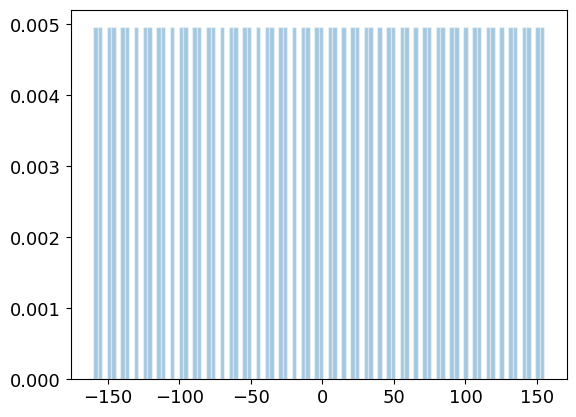

In [24]:
x, kde_uniform = gen_kde(np.arange(-160,160,5),10)

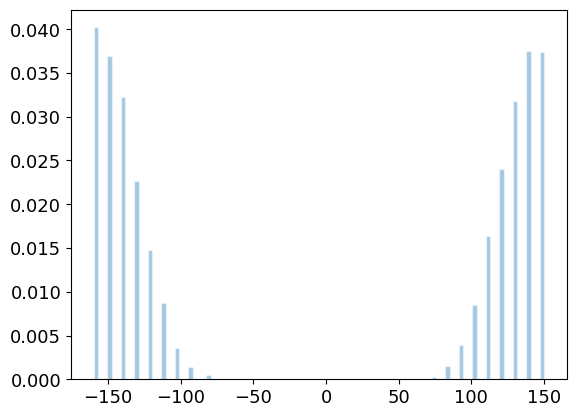

In [25]:
x, kde_po = gen_kde(np.array(po_output), sigma=10.0)

In [26]:
def kl_divergence(a, b):
    return [a[i] * np.log(a[i]/b[i]) for i in range(len(a))] #sum(a[i] * np.log(a[i]/b[i]) for i in range(len(a)))

In [27]:
kl_i = kl_divergence(kde_po, kde_uniform)

In [28]:
kl = np.sum(kl_i)

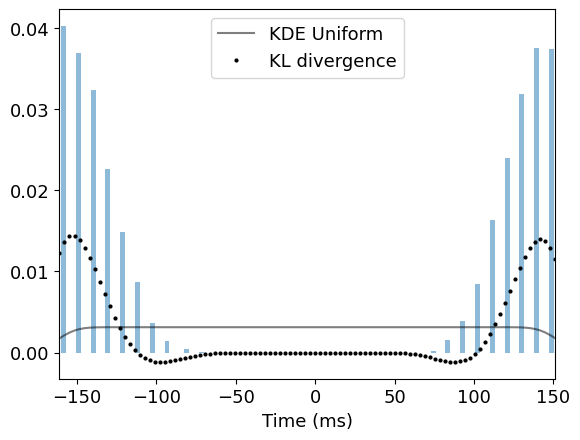

In [29]:
plt.hist(np.array(po_output), bins = 100, density=True, alpha = 0.5);
plt.plot(x, kde_uniform, color="k", alpha=0.5, label=f"KDE Uniform")
plt.plot(x, kl_i, "o", color="k", markersize=2, label= "KL divergence")
plt.xlim(x[0], x[-1])
plt.xlabel('Time (ms)')
plt.legend()
plt.show()

## Sorting

In [30]:
poo_idx = np.argsort(np.array(po_output), axis=-1, kind=None, order=None)

In [31]:
poo_idx

array([10630, 10636, 10573, ...,    64,  5689,  5688])

In [32]:
#po_output[poo_idx]

sorted_spktm = [po_output[n] for n in poo_idx]

In [33]:
sorted_spktm = [spktm[n] for n in poo_idx]

Text(0, 0.5, '#Neuron')

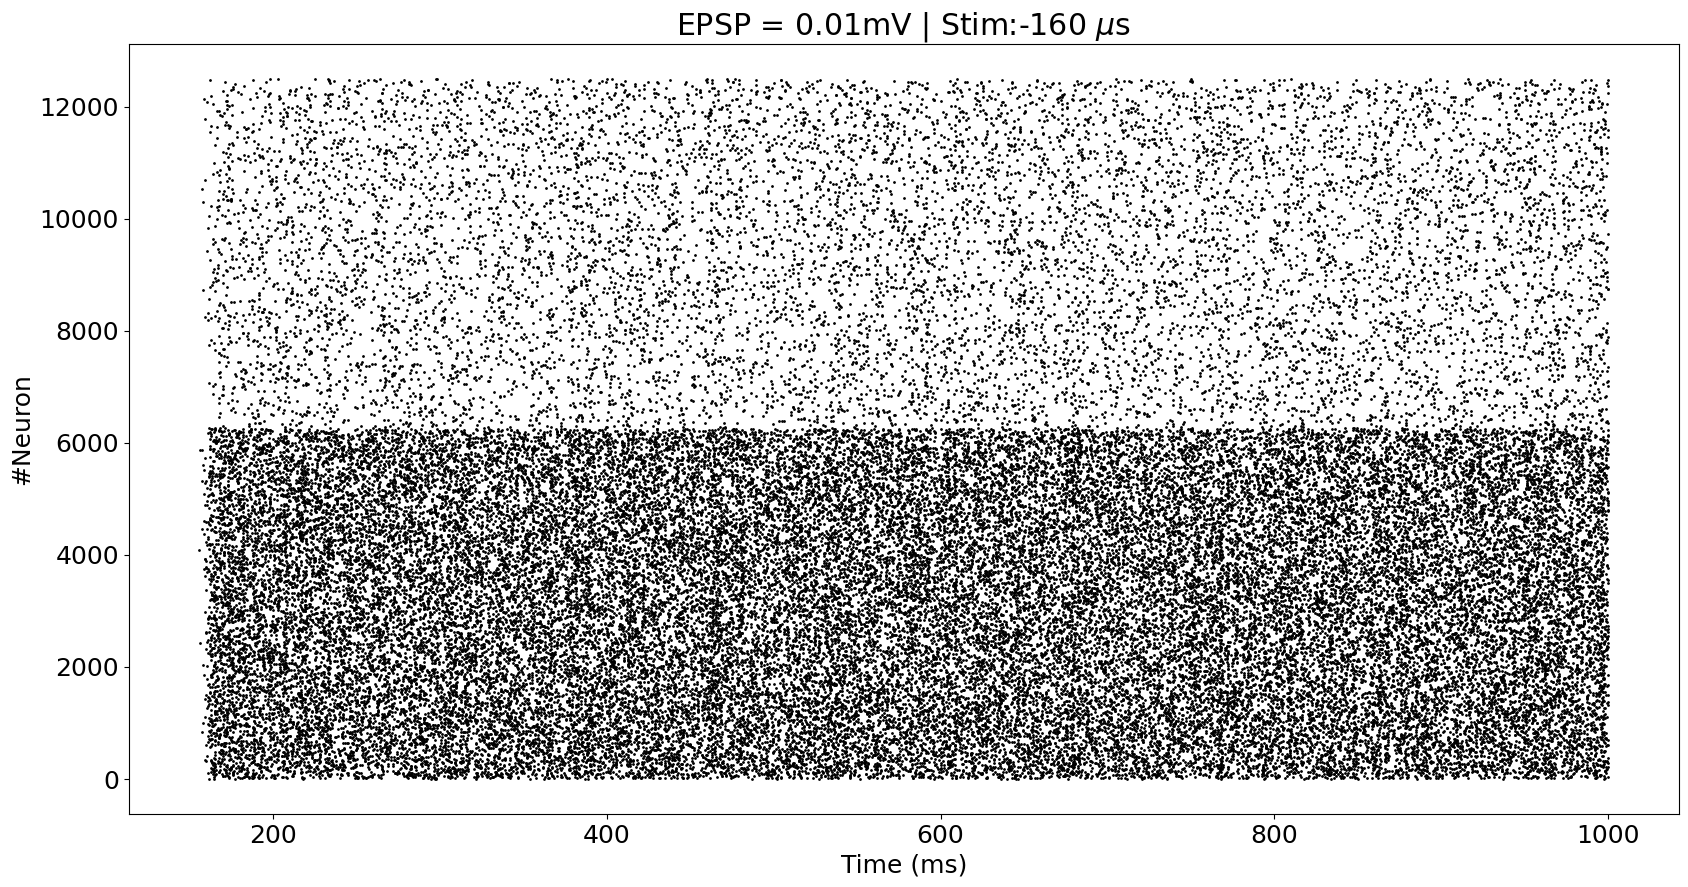

In [35]:
plt.rcParams.update({'font.size': 18})
plot_raster(sorted_spktm, colors= ["k", "k"])
plt.title(f'EPSP = {0.01}mV | Stim:-160 $\mu$s')
plt.xlabel("Time (ms)")
plt.ylabel("#Neuron")

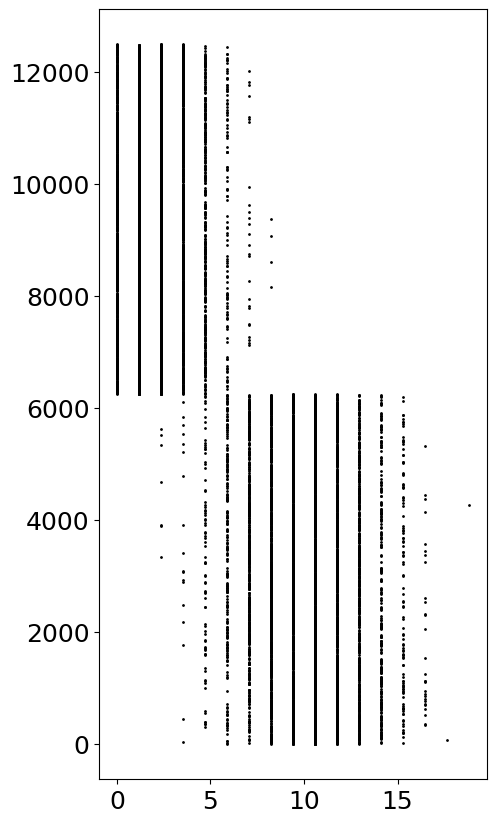

In [37]:
plt.figure(figsize=(5,10))
for i, j in enumerate(poo_idx):
    plt.plot(frs[j], i,"o", c="k", markersize=1)
#plt.save 

## One neuron responses

In [36]:
spkts = {}
tr = 0 

for st in range(len(stim_range)):
    spkts[str(st)] = generate_spktm(files[tr][st])

In [37]:
n = 8771#np.random.randint(1,N)

In [38]:
n

8771

In [39]:
po_init[n]

-160.0

Text(0, 0.5, 'ITD ($\\mu$s)')

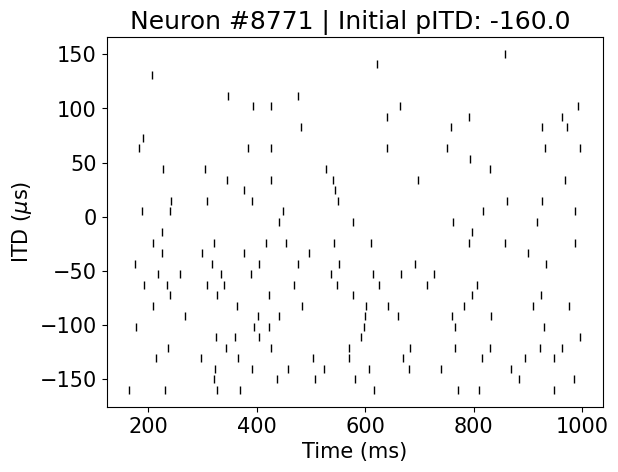

In [41]:
plt.rcParams.update({'font.size': 15})
for i, st in enumerate(stim_range):
    plt.plot(spkts[str(i)][n], st*np.ones(len(spkts[str(i)][n])), "|", color='k')
plt.title(f'Neuron #{n} | Initial pITD: {po_init[n]} ')
plt.xlabel('Time (ms)')
plt.ylabel('ITD ($\mu$s)')
#plt.plot(frs[j], i,"o", c="k", markersize=1)

## Metrics

In [42]:
import scipy.optimize
import numpy as np

###
# Fourier components
def _fft_(x):
    n = len(x)
    z = np.fft.fft(x)
    f0 = abs(z[0])/n      # mean     
    f1 = abs(z[1])/(n/2) # 1st order
    return f0, f1

###
# OSI: 1- CV; CV: sum(r exp(j*2*t))/sum(r): t=0...pi (rad)
def _osv_(r, t):
    z = np.sum(r * np.exp(1j *2.*t))/np.sum(r)
    osi = abs(z)  #osi
    #po = np.angle(z) %(2*np.pi) #PO
    return osi

###
# fit von-Mises
def vonMises(xdata,ydata):
    # define a von-Mises fitting function: B + A exp(k cos(2(theta - phi)) -1)
    # p[0] = B
    # p[1] = A
    # p[2] = k (1/D)
    # p[3] = phi
    fitfunc = lambda p, x: p[0] + p[1] * \
                           np.exp( p[2]*( np.cos(2*(x - p[3]))-1.) )
    errfunc = lambda p, x, y: fitfunc(p,x)-y
    
    # initial guess
    p0 = [1., 1., 1., 1.]
    # fit
    p1, success = scipy.optimize.leastsq(errfunc, p0[:],args=(xdata,ydata))
    
    tw = (90./np.pi) * np.arccos(abs(1 + np.log((1.+np.exp(-2.*p1[2]))/2)/p1[2]) )
    
    return p1, fitfunc(p1,xdata), tw, success


In [43]:
OS_idx = []
for i in range(len(tc_mean[0])):
    osi = _osv_(tc_mean[:,i], stim_range)
    OS_idx.append(osi)

In [44]:
np.shape(OS_idx)

(12500,)

In [45]:
# number of LGN neurons contacting one cortical neuron
n_ffw = 50.
# average firing rate of LGN neurons
r_ffw = 20.
# overall rate of the feedforward input
r_base = n_ffw * r_ffw
# modulation in the input
input_mod = 0.1

In [46]:
np.mean(OS_idx)

0.08571179710390697

In [47]:
def ITD_to_rad(x, mITD=160):
    return (x+mITD)/((2*mITD)/np.pi)

In [48]:
r_base = 1
input_mod = 0.1

tc_left = r_base *(1.+ input_mod* np.cos(1*(ITD_to_rad(stim_range) - ITD_to_rad(-160)) ))

tc_right = r_base *(1.+ input_mod* np.cos(1*(ITD_to_rad(stim_range) - ITD_to_rad(160)) ))

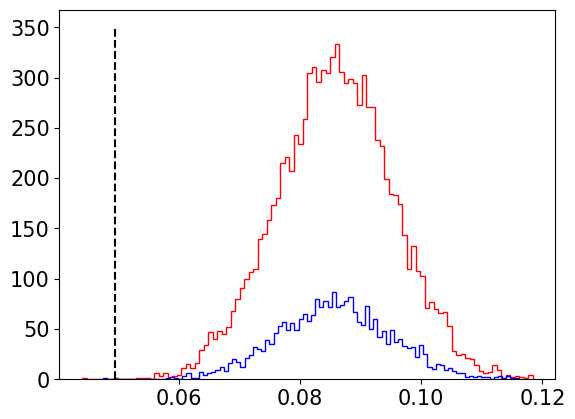

In [49]:
hist = plt.hist(OS_idx[:int(N*0.8)], bins=100, histtype='step', color='r')
hist = plt.hist(OS_idx[int(N*0.8):], bins=100, histtype='step', color='b')
plt.vlines(_osv_(tc_left, stim_range),0,350, linestyles='--', color="k")

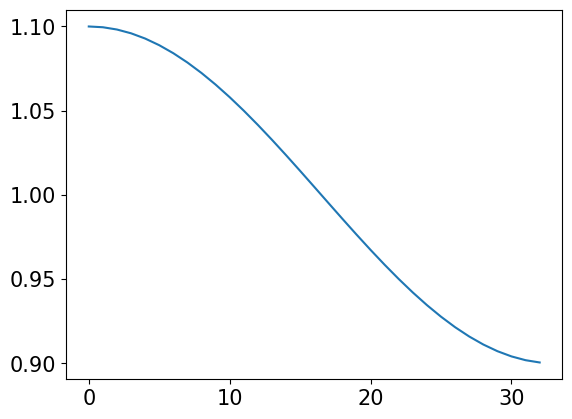

In [50]:
plt.plot(tc_left)

In [51]:
_osv_(tc_left, stim_range)

0.04932133782870689

In [52]:
_osv_(tc_right, stim_range)

0.049453958380697466

# EPSP=0.2mV

In [53]:
files_02 = []

for tr in range(trial_no):
    file_02 = []
    for stim in range(stim_no):
        file_02.append(pega_resultados('Results/N12500g8_Jrec=0.2/spikes-all-st{stim}-tr{tr}-12501-{core}.dat', tr, stim))
    files_02.append(file_02)
    

In [54]:
len(files_02)

20

In [55]:
spktm_02 = generate_spktm(files_02[0][0])

Text(0.5, 0, 'Time (ms)')

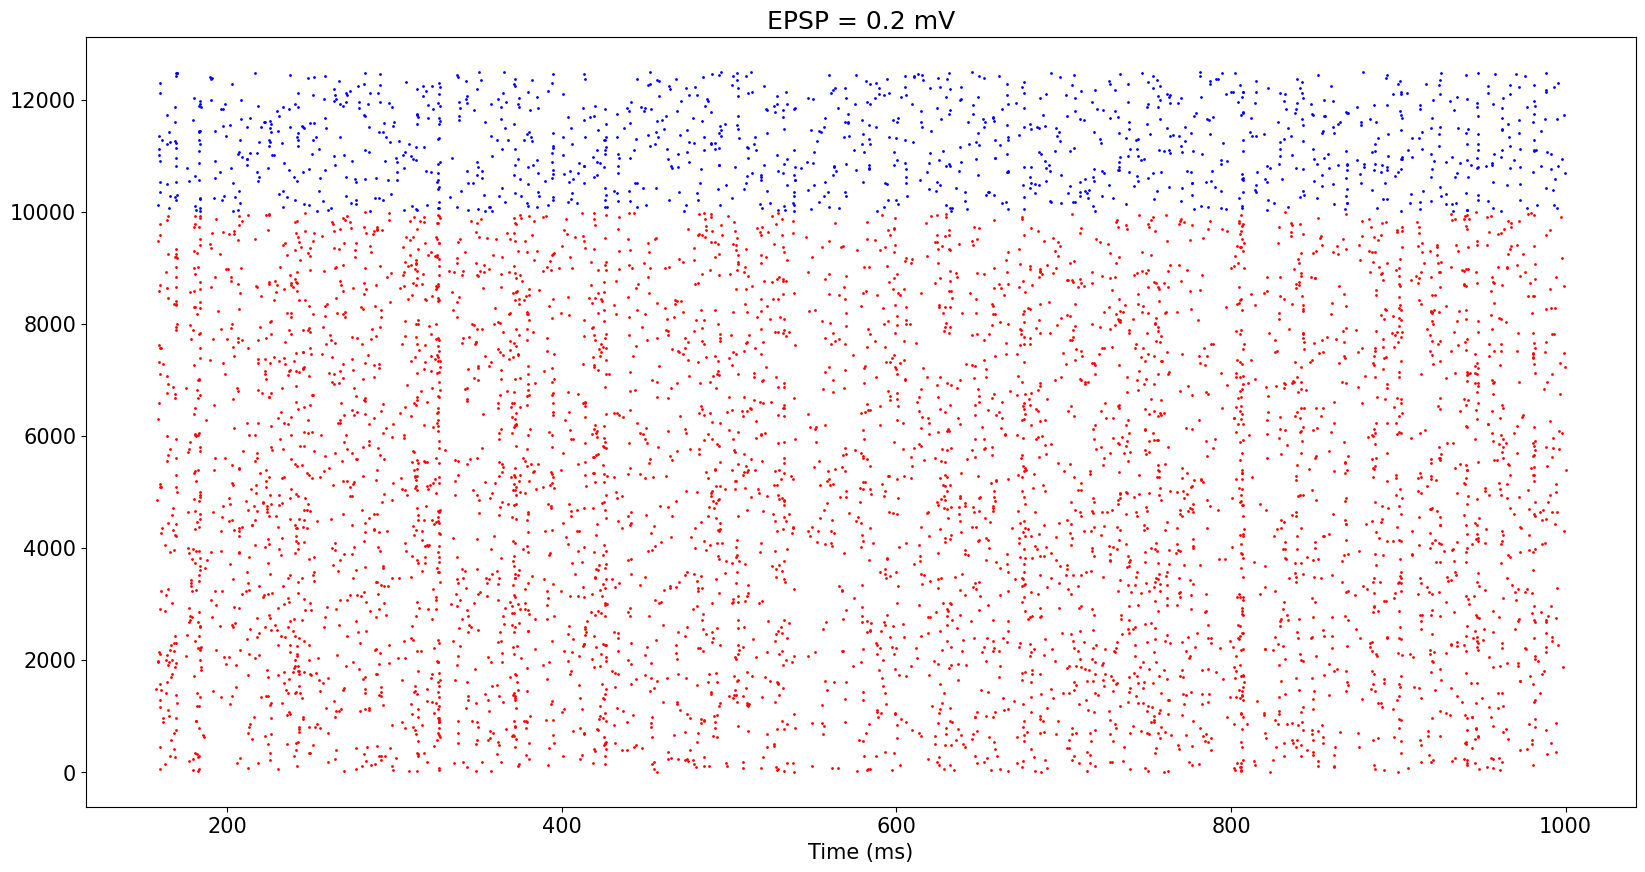

In [56]:
plot_raster(spktm_02)
plt.title('EPSP = 0.2 mV')
plt.xlabel('Time (ms)')

In [57]:
frs_02 = calculate_fr(files_02[0][0])

In [58]:
#tcs_02 = gen_all_TC(files_02)
#file = open('tcs_Jrec=0.2', 'wb'); pickle.dump(tcs_02, file); file.close()
f = open('tcs_Jrec=0.2', 'rb'); tcs_02 = pickle.load(f); f.close()

In [59]:
tc_02_mean = np.mean(tcs_02, axis=0)

In [60]:
po_output_02 = []
for n in range(N):
    poo = list(tc_02_mean[:,n]).index(max(tc_02_mean[:,n]))
    po_output_02.append(np.mean(stim_range[poo]))

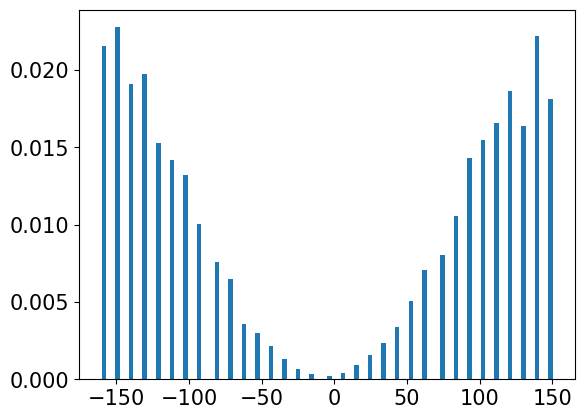

In [61]:
plt.hist(np.array(po_output_02), bins = 100, density=True);

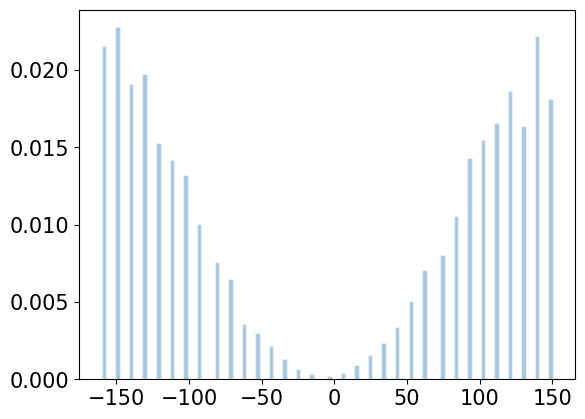

In [62]:
x, kde_po_02 = gen_kde(np.array(po_output_02), sigma=10.0)

In [63]:
kl_i_02 = kl_divergence(kde_po_02, kde_uniform)

In [64]:
kl_02 = sum(kl_i_02)

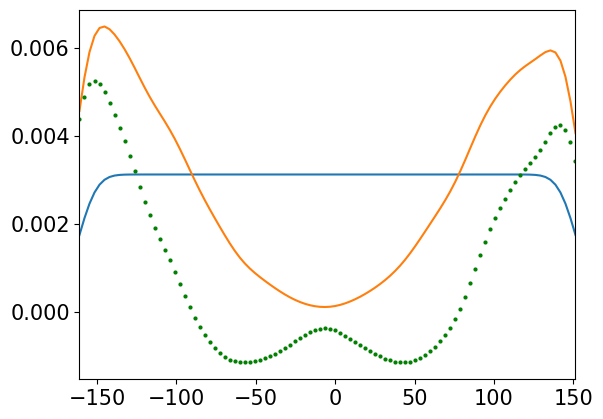

In [65]:
plt.plot(x, kde_uniform)
plt.plot(x, kde_po_02)
plt.plot(x, kl_i_02, "o", color="g", markersize=2)
plt.xlim(x[0], x[-1])
plt.show()

In [66]:
kl_02

0.09212183279977094

In [67]:
OS_02_idx = []
for i in range(len(tc_mean[0])):
    osi = _osv_(tc_02_mean[:,i], stim_range)
    OS_02_idx.append(osi)

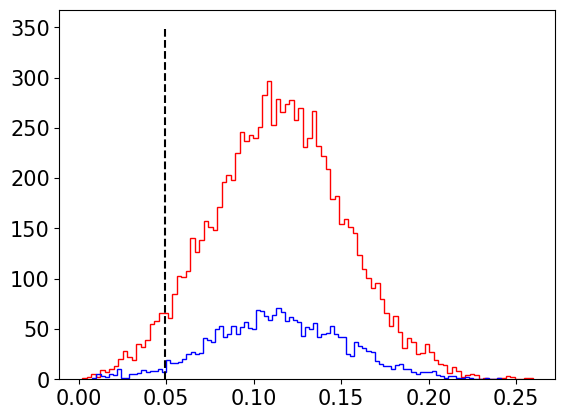

In [68]:
hist = plt.hist(OS_02_idx[:int(N*0.8)], bins=100, histtype='step', color='r')
hist = plt.hist(OS_02_idx[int(N*0.8):], bins=100, histtype='step', color='b')
plt.vlines(_osv_(tc_left, stim_range),0,350, linestyles='--', color="k")

# EPSP=0.5mV

In [69]:
files_05 = []

for tr in range(trial_no):
    file_05 = []
    for stim in range(stim_no):
        file_05.append(pega_resultados('Results/N12500g8_Jrec=0.5/spikes-all-st{stim}-tr{tr}-12501-{core}.dat', tr, stim))
    files_05.append(file_05)
    

In [70]:
len(files_05)

20

In [71]:
spktm_05 = generate_spktm(files_05[0][0])

Text(0.5, 0, 'Time (ms)')

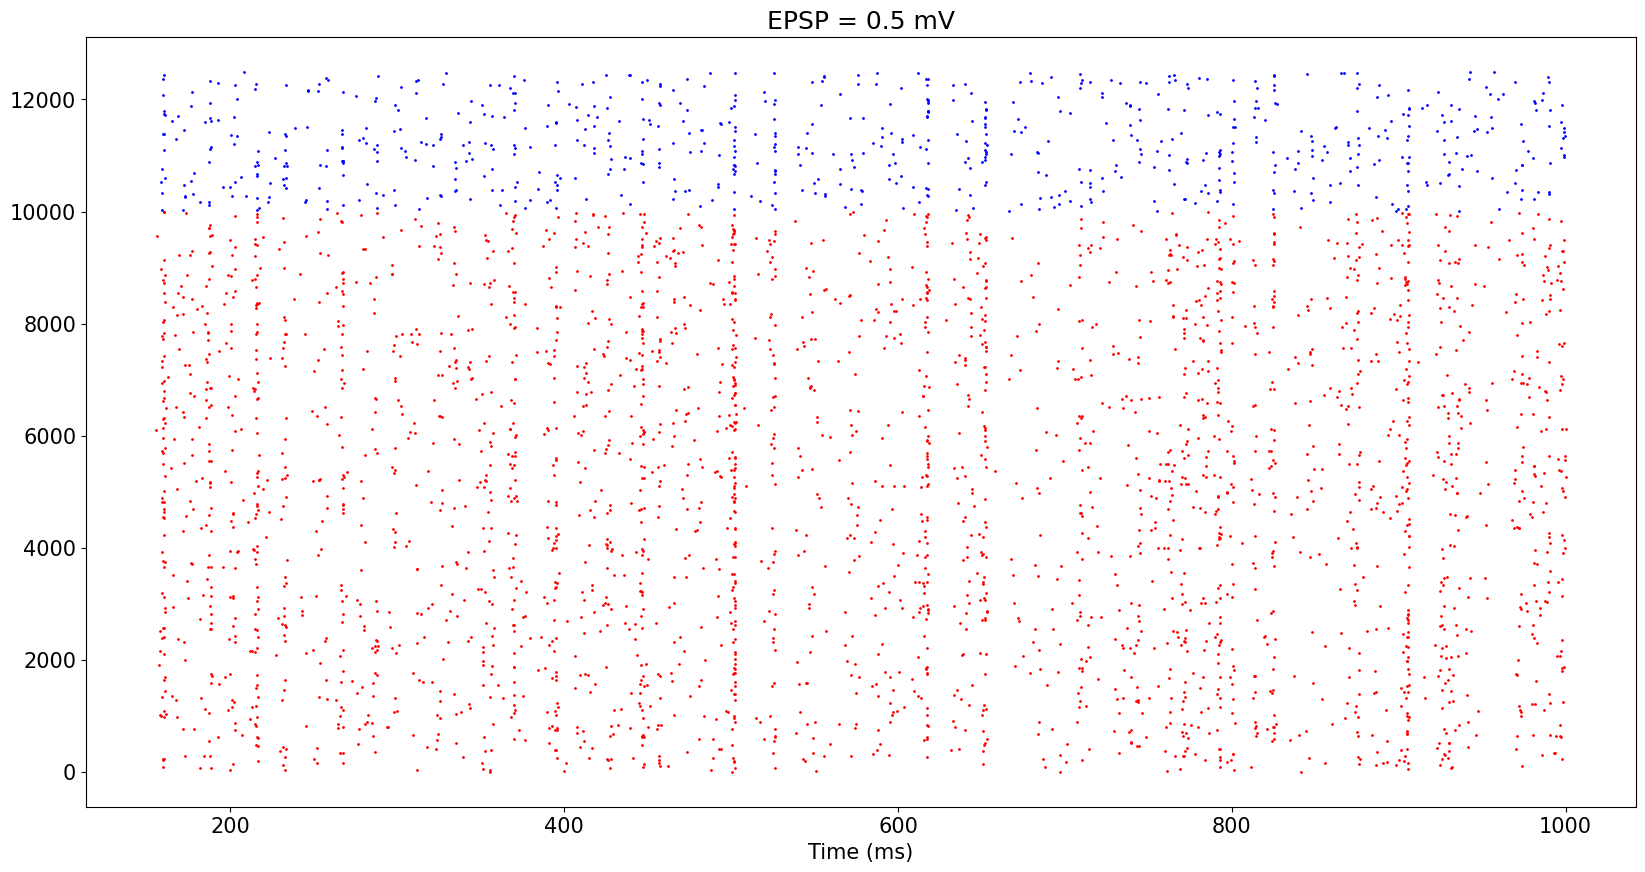

In [72]:
plot_raster(spktm_05)
plt.title('EPSP = 0.5 mV')
plt.xlabel('Time (ms)')

In [73]:
frs_05 = calculate_fr(files_05[0][0])

In [74]:
#tcs_05 = gen_all_TC(files_05)
#file = open('tcs_Jrec=0.5', 'wb'); pickle.dump(tcs_05, file); file.close()
f = open('tcs_Jrec=0.5', 'rb'); tcs_05 = pickle.load(f); f.close()

In [75]:
tc_05_mean = np.mean(tcs_05, axis=0)

In [76]:
po_output_05 = []
for n in range(N):
    poo = list(tc_05_mean[:,n]).index(max(tc_05_mean[:,n]))
    po_output_05.append(np.mean(stim_range[poo]))

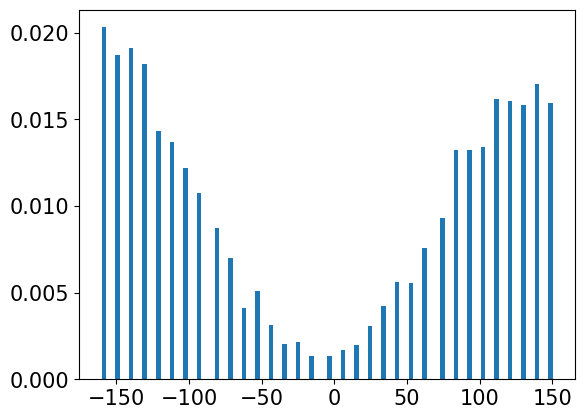

In [77]:
plt.hist(np.array(po_output_05), bins = 100, density=True);

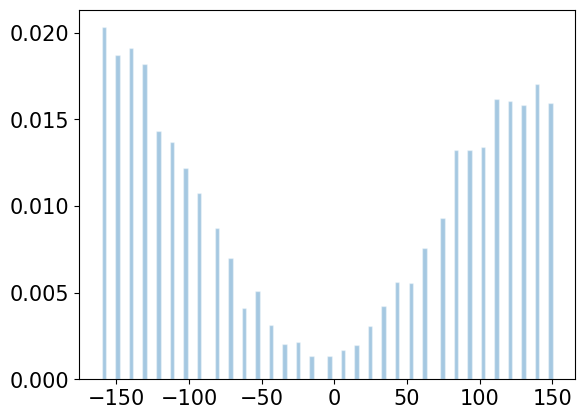

In [78]:
x, kde_po_05 = gen_kde(np.array(po_output_05), sigma=10.0)

In [79]:
kl_i_05 = kl_divergence(kde_po_05, kde_uniform)

In [80]:
kl_05 = sum(kl_i_05)

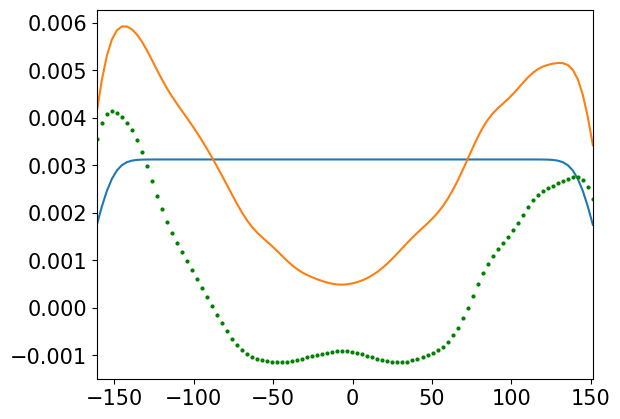

In [81]:
plt.plot(x, kde_uniform)
plt.plot(x, kde_po_05)
plt.plot(x, kl_i_05, "o", color="g", markersize=2)
plt.xlim(x[0], x[-1])
plt.show()

In [82]:
kl_05

0.05911416473950016

In [83]:
OS_05_idx = []
for i in range(len(tc_mean[0])):
    osi = _osv_(tc_05_mean[:,i], stim_range)
    OS_05_idx.append(osi)

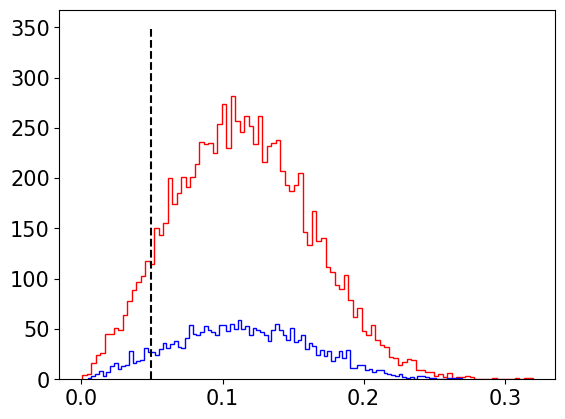

In [84]:
hist = plt.hist(OS_05_idx[:int(N*0.8)], bins=100, histtype='step', color='r')
hist = plt.hist(OS_05_idx[int(N*0.8):], bins=100, histtype='step', color='b')
plt.vlines(_osv_(tc_left, stim_range),0,350, linestyles='--', color="k")

# Comparing different EPSPs

Text(0, 0.5, 'Count')

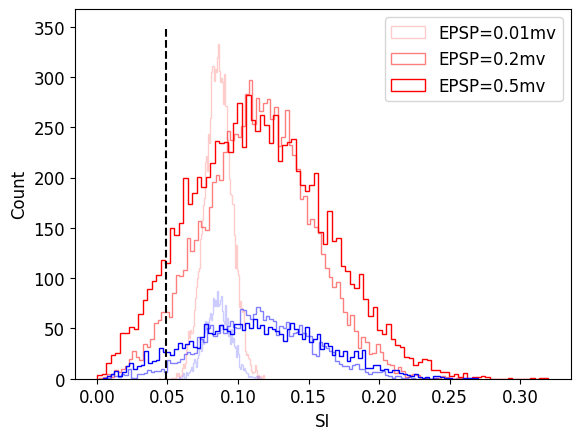

In [88]:
hist = plt.hist(OS_idx[:int(N*0.8)], bins=100, histtype='step', color='r', alpha=0.2, label=f'EPSP={0.01}mv')
hist = plt.hist(OS_idx[int(N*0.8):], bins=100, histtype='step', color='b', alpha=0.2)
hist = plt.hist(OS_02_idx[:int(N*0.8)], bins=100, histtype='step', color='r', alpha=0.5, label=f'EPSP={0.2}mv')
hist = plt.hist(OS_02_idx[int(N*0.8):], bins=100, histtype='step', color='b',alpha=0.5)
hist = plt.hist(OS_05_idx[:int(N*0.8)], bins=100, histtype='step', color='r',alpha=1, label=f'EPSP={0.5}mv')
hist = plt.hist(OS_05_idx[int(N*0.8):], bins=100, histtype='step', color='b', alpha=1)
plt.vlines(_osv_(tc_left, stim_range),0,350, linestyles='--', color="k")
plt.legend()
plt.xlabel('SI')
plt.ylabel('Count')

In [86]:
#PO calculation from the function not coeherent with what we are trying to do

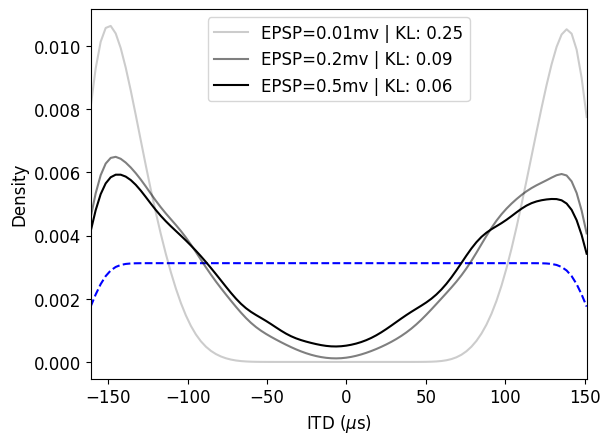

In [87]:
plt.rcParams.update({'font.size': 12})
plt.plot(x, kde_uniform, color="b",linestyle='--')
plt.plot(x, kde_po, color="k", alpha=0.2, label=f'EPSP={0.01}mv | KL: {np.round(kl,2)}')
plt.plot(x, kde_po_02, color="k", alpha=0.5, label=f'EPSP={0.2}mv | KL: {np.round(kl_02,2)}')
plt.plot(x, kde_po_05, color="k", alpha=1, label=f'EPSP={0.5}mv | KL: {np.round(kl_05,2)}')
plt.legend()
#plt.plot(x, kl_i_05, "o", color="g", markersize=2)
plt.xlim(x[0], x[-1])
plt.xlabel("ITD ($\mu$s)")
plt.ylabel("Density")
plt.show()

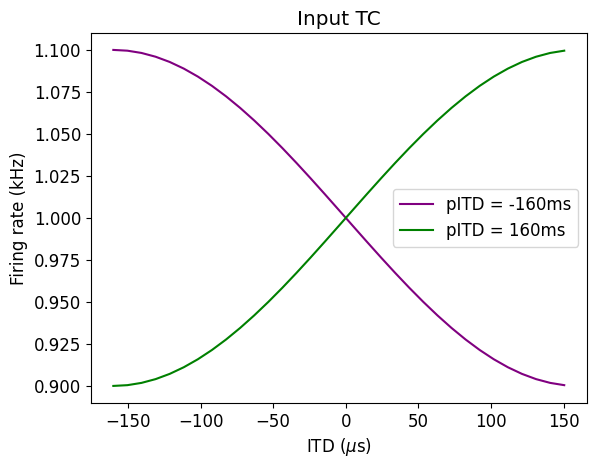

In [90]:
plt.rcParams.update({'font.size': 12})
plt.plot(stim_range, tc_left, color="purple", label=f"pITD = {-160}ms")
plt.plot(stim_range, tc_right, color="green", label=f"pITD = {160}ms")
plt.xlabel("ITD ($\mu$s)")
plt.ylabel("Firing rate (kHz)")
plt.title("Input TC")
plt.legend()

In [ ]:
plt.rcParams.update({'font.size': 13})
plt.hist(np.array(po_init), bins = 100, color="k");
#plt.title(f"EPSP:{0.2}mV")
plt.ylabel("Count")
plt.xlabel("Input pITD")

In [ ]:
_osv_(tc_left, stim_range)